## Averaged flows


In [234]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean
import os
import sys
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder
%matplotlib qt

experiment = "s19" 

def divergence_npgrad(flow):
    # flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy


def analyze_defects(img):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, 25)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf



# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [61]:
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

PLOT = True

# image_list = glob.glob(r"C:/Users/victo/Downloads/SB_lab/RPE1_C2C12_/Test001/*.tif")
image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[20:120:1]

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
    # v = np.zeros_like(u)


for im1, im2 in zip(image_list[:-1], image_list[1:]):
    print(os.path.basename(im1))
    img1 = cv2.imread(im1)[:,:,0]
    
    # calculate velocity and plot fields
    if PLOT:
        ax.clear()
        img2 = cv2.imread(im2)[:,:,0]
        flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
        # >> uncomment to have average flow representation
        # >>  TO DO devide by number of frames
        # u += flow[..., 0]
        # v += flow[..., 1]
        # flow = np.stack((u, v), axis=-1)

        divergence = gaussian_filter(divergence_npgrad(flow), sigma=30)

        # Apply Contrast Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(255-img_clahe, "gray")
        ax.imshow(divergence, "jet", alpha=.3, vmin=-0.03, vmax=0.03)

    ori, plushalf, minushalf = analyze_defects(img1)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_t")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)
    
    if PLOT:
        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
    
    
        save_path = os.path.join(
            r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
            experiment,
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))
    # break    

minushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/MinusHalf1.csv")
plushalf_df.to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusHalf1.csv")

RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t21.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t22.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t23.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t24.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t25.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t26.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t27.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t28.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t29.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t30.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t31.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t32.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t33.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t34.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t35.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t36.TIF
RPE1_Fucci_C2C12_5x_15min_phase_nuclei_w1Trans_s19_t37.T

In [2]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

In [63]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    # ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_", 
        experiment,
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    # break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             


    # break



## Import CSVs

In [140]:
first_frame, last_frame

(101, 199)

In [3]:
experiment = "s14" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders
last_frame = minushalf_df["frame"].max() # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

  ////////    PLUS   //////////
[(83, 20), (83, 20), (77, 20), (78, 20), (73, 20), (73, 20), (73, 20), (69, 20), (71, 20), (66, 20)]
[(83, 10), (83, 10), (77, 10), (78, 10), (73, 10), (73, 10), (73, 10), (70, 10), (71, 10), (66, 10)]

 ////////    MINUS   //////////
[(82, 20), (80, 20), (79, 20), (78, 20), (72, 20), (70, 20), (72, 20), (70, 20), (71, 20), (64, 20)]
[(82, 10), (80, 10), (79, 10), (78, 10), (72, 10), (70, 10), (72, 10), (70, 10), (71, 10), (64, 10)]


## Find shift and rescale

slope: 2.2158362658984307 | intercept: -161.03423610717925
slope: 2.2158362658984307 | intercept: -161.03423610717925
slope: 2.215913153503683 | intercept: -161.08011350180263
-------  X  ------------
slope: 2.216268980773293 | intercept: -152.2695712848465
slope: 2.216268980773293 | intercept: -152.2695712848465
slope: 2.2162530683878185 | intercept: -152.21589474138142
-------  Y  ------------


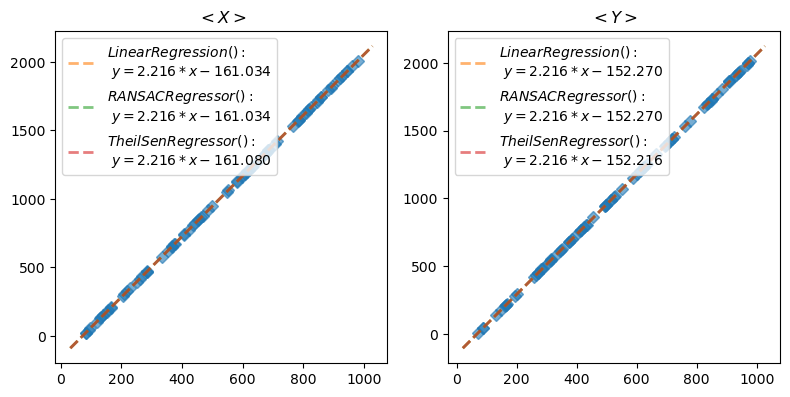

In [4]:
from sklearn import linear_model

%matplotlib inline
frame = 1

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        # !!! insert image height (e.g. 2048)
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

### Validate shift and rescale

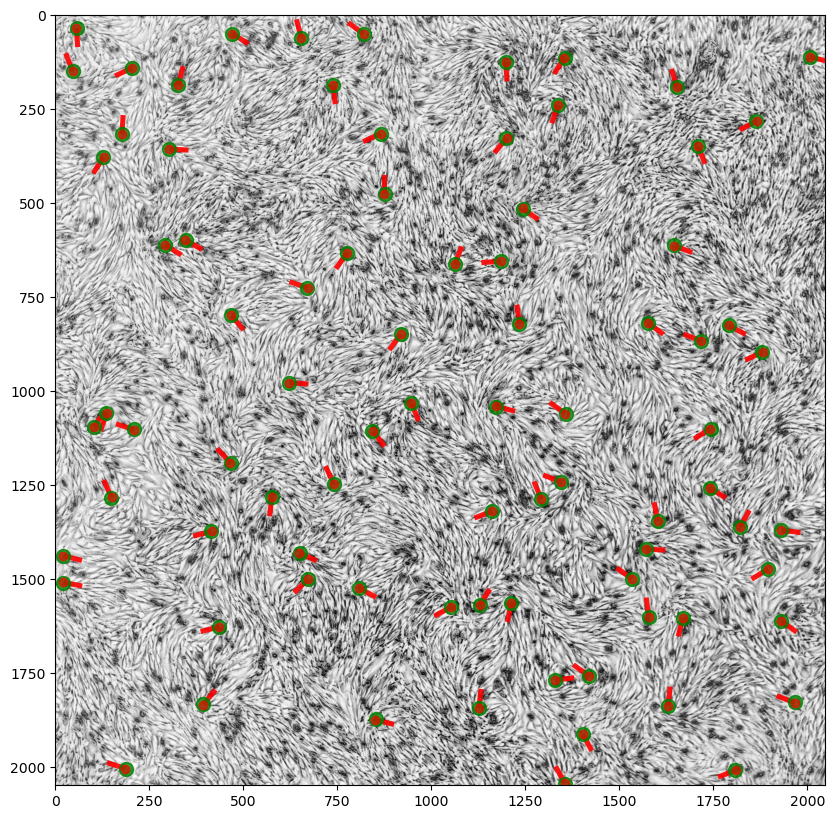

In [5]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 1

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusTM_spots.csv', skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/PlusHalf1.csv')

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [6]:
%matplotlib qt
# SLOPEx = 2.2020369696888773
# INTERCEPTx = -153.5892752236614
# SLOPEy = 2.589611169431241
# INTERCEPTy = -152.43827493084723

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

# experiment = "s15" 

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + '/MinusHalf1.csv')
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusHalf1.csv')

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/MinusTM_spots.csv', skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment +'/PlusTM_spots.csv', skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [7]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


[[ 291.  612.]
 [1062.  662.]
 [1184.  654.]] 
 [[ 290.98629803  611.19062295]
 [1062.10623752  662.16468751]
 [1183.97864175  653.29963281]] 
 [[ 291.  612.]
 [1062.  662.]
 [1184.  654.]]
--------------
[[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]] 
 [[1624.93515888 1553.10268552]
 [1556.24344013 1555.3189492 ]
 [1101.99175164 1612.94180479]] 
 [[1626. 1553.]
 [1557. 1556.]
 [1102. 1613.]]
--------------


In [163]:
# replace and add angles
# plushalf_TM[['x_img1','y_img1','ang1','charge']] =  plushalf_df[['x', 'y', 'ang1', 'charge']].iloc[idx[:]].values

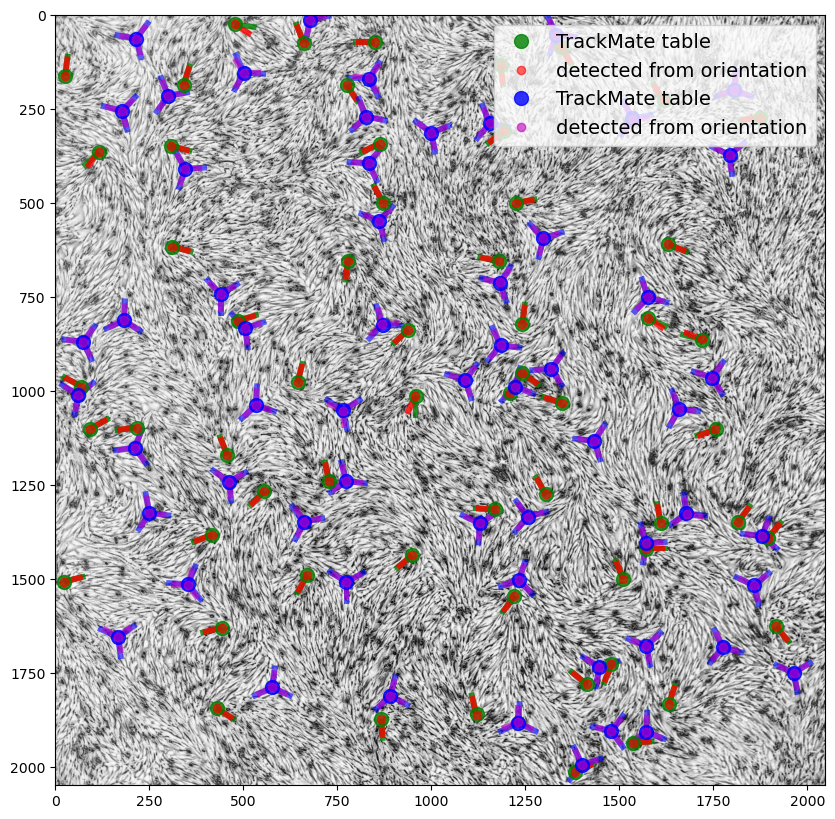

In [8]:
# test replaced values
%matplotlib inline
frame = 20

image_list_all = glob.glob(r"C:\Users\victo\My Drive\Curie\Trinish\30_01_18_RPE1_C2C12_5x_phase_nuclei\*" + experiment + "*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [165]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")

# Start Here Find Pairs

In [431]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean
import os
import sys
import pandas as pd
import seaborn as sns

experiment = "s19"
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_/" + experiment + "/PlusAndMinusTM.csv")
plus_minus_df.head()

Unnamed: 0     LABEL      ID  TRACK_ID    QUALITY  POSITION_X  POSITION_Y  \
0           0  ID901391  901391      26.0  81.421509       657.0        88.0   
1           1  ID901390  901390      89.0  81.421509       860.0        86.0   
2           2  ID901405  901405     124.0  74.827904       242.0       205.0   
3           3  ID901404  901404      35.0  81.421509       844.0       192.0   
4           4  ID901407  901407      34.0  81.421509       718.0       220.0   

   POSITION_Z  POSITION_T  FRAME  ...  CONTRAST_CH1   SNR_CH1        x_img  \
0         0.0         0.0      0  ...      0.973672  1.625018  1293.144897   
1         0.0         0.0      0  ...      0.973672  1.625018  1740.161345   
2         0.0         0.0      0  ...      0.977139  1.318006   379.293538   
3         0.0         0.0      0  ...      0.973672  1.625018  1704.928521   
4         0.0         0.0      0  ...      0.973672  1.625018  1427.470036   

         y_img  x_img1  y_img1      ang1  ang2  ang3  charge  
0  1972.526759  1293.0  1972.0  2.073451   NaN   NaN     0.5  
1  1977.706022  1740.0  1978.0  0.000000   NaN   NaN     0.5  
2  1669.539881   380.0  1670.0 -1.570796   NaN   NaN     0.5  
3  1703.205090  1705.0  1704.0  1.319469   NaN   NaN     0.5  
4  1630.695409  1427.0  1632.0 -1.759292   NaN   NaN     0.5  

[5 rows x 29 columns]

In [432]:
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)   


pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<50
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 
    # break

pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [433]:
radius = 1000
neighbour_dist = []
for frame in plus_minus_df["FRAME"].unique()[:]:
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    tree = KDTree(plus_xy[["x_img1","y_img1"]]) #map all +1/2 defects

    # for each -1/2 map distances to +1/2 neighbours in RADIUS
    for index, row in minus_xy.iterrows():
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind, dist = tree.query_radius(np.array(row[['x_img1','y_img1']]).reshape(1, -1), 
                                      r=radius, return_distance=True, sort_results=True)
        # find [-1/2, +1/2] pair TRACK_IDs
        try:
            plus_neighbours = plus_xy.iloc[ind[0]].copy()
            plus_neighbours["DIST"] = dist[0]
            plus_pair_id = pairs_df["plus"][pairs_df["minus"]==row["TRACK_ID"]].values[0]
            plus_neighbours["PAIR"] = 1*(plus_neighbours["TRACK_ID"] == plus_pair_id)

            plus_neighbours["mp_ang"] = plus_neighbours["ang1"] - np.arctan2(
                row['y_img1']-plus_neighbours["y_img1"], 
                row['x_img1']-plus_neighbours["x_img1"]
                )

            # TODO stack "plus_neighbours" 
            neighbour_dist.append(plus_neighbours[["PAIR","DIST","mp_ang", "TRACK_ID"]].to_numpy())
        except:
            pass

    #     break
    # break

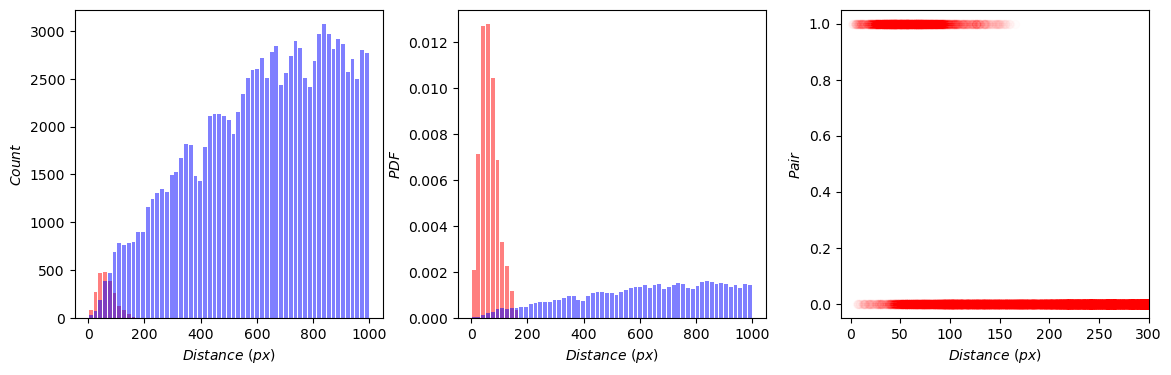

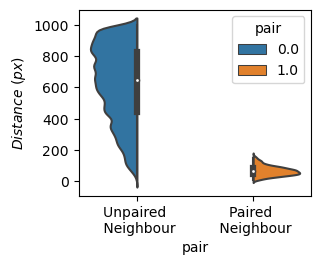

In [434]:
%matplotlib inline
pair_TF = np.concatenate(neighbour_dist)[:,0]
distance = np.concatenate(neighbour_dist)[:,1]
pairs_idx = pair_TF==1
df = pd.DataFrame(data={"pair": pair_TF, 
                        "distance": distance,
                        "mp_ang": np.concatenate(neighbour_dist)[:,2],
                        "TRACK_ID": np.concatenate(neighbour_dist)[:,3],
                        }).dropna()


bins_number = 60
bins = np.linspace(0, radius, bins_number)
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
# p1 = ax1.hist(distance[pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="red")
# p2 = ax1.hist(distance[~pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="blue")
p1 = ax1.hist(df["distance"][df["pair"]==1], bins, density=False, rwidth=.8, alpha=.5, color="red")
p1 = ax1.hist(df["distance"][df["pair"]==0], bins, density=False, rwidth=.8, alpha=.5, color="blue")
ax1.set_xlabel("$Distance ~(px)$")
ax1.set_ylabel("$Count$")
ax1.set_box_aspect(1)

# p1 = ax2.hist(distance[pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="red")
# p2 = ax2.hist(distance[~pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="blue")
p1 = ax2.hist(df["distance"][df["pair"]==1], bins, density=True, rwidth=.8, alpha=.5, color="red")
p1 = ax2.hist(df["distance"][df["pair"]==0], bins, density=True, rwidth=.8, alpha=.5, color="blue")
ax2.set_xlabel("$Distance ~(px)$")
ax2.set_ylabel("$PDF$")
ax2.set_box_aspect(1)

ax3.plot(df["distance"],df["pair"], "or", alpha=.01)
ax3.set_xlabel("$Distance ~(px)$")
ax3.set_ylabel("$Pair$")
ax3.set_xlim([-10,300])
ax3.set_box_aspect(1)

# sns.violinplot([distance[pairs_idx], distance[~pairs_idx]], ax=ax3, split=True)

fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(data=df, x="pair", y="distance", ax=ax, hue="pair", split=True)
# sns.stripplot(data=df, x="pair", y="distance", ax=ax, marker=".", alpha=.01)
ax.set_xticklabels(["Unpaired \n Neighbour", "Paired \n Neighbour",])
ax.set_ylabel("$Distance ~(px)$")
ax.set_box_aspect(.8)
# TODO consider relative angle

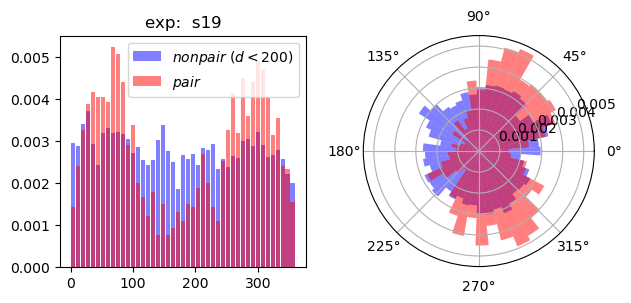

In [435]:
%matplotlib inline
SAVE=True
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
nonpair_ang = df["mp_ang"][
    np.logical_and(df["pair"]==0, df["distance"]<200)
    ] % (2*np.pi)
pair_ang = df["mp_ang"][df["pair"]==1] % (2*np.pi)

fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

ax1.set_title(r"exp:  " + experiment)
nonpair, _, _ =  ax1.hist(nonpair_ang*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="blue", label="$nonpair~(d<200)$")
pair, _, _ =  ax1.hist(pair_ang*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="red", label="$pair$")

ax1.legend(loc='upper right')

width = 2 * np.pi / bins_number
ax2.bar(bins[:bins_number], nonpair, color="blue",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], pair, color="red",width=width, bottom=0.0, alpha=.5)
if SAVE:
    fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/pair-nonpair_ang_distribution_hist_" + experiment +".png")


<AxesSubplot: xlabel='mp_ang', ylabel='distance'>

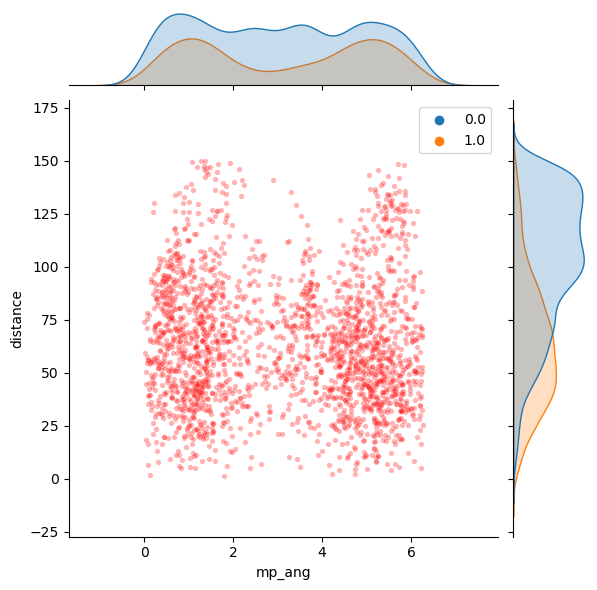

In [450]:
nonpair_ang = df[["mp_ang", "distance","pair"]][
    # np.logical_and(df["pair"]==1, df["distance"]<200)
    df["distance"]<150#df["distance"][df["pair"]==1].max()
    ]
nonpair_ang["mp_ang"] = nonpair_ang["mp_ang"] % (2*np.pi)
g = sns.jointplot(data=nonpair_ang, x="mp_ang", y="distance", 
     hue="pair", alpha=.0, marker=".",)

sns.scatterplot(x=nonpair_ang["mp_ang"][nonpair_ang["pair"]==0], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==0], 
    s=0, color="blue", ax=g.ax_joint, alpha=.2)   

sns.scatterplot(x=nonpair_ang["mp_ang"][nonpair_ang["pair"]==1], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==1], 
    s=15, color="red", ax=g.ax_joint, alpha=.3) 

In [438]:
nonpair_ang

mp_ang    distance  pair
0       5.434955   41.012193   1.0
1       4.818342   72.567210   0.0
2       5.801651  133.958949   0.0
47      5.877257   77.929455   1.0
48      5.059134  126.530629   0.0
...          ...         ...   ...
119558  5.382116   96.540147   0.0
119571  1.352605   25.079872   0.0
119587  4.568340   65.375837   0.0
119588  0.119829   69.835521   0.0
119627  1.481379  146.372812   0.0

[6221 rows x 3 columns]

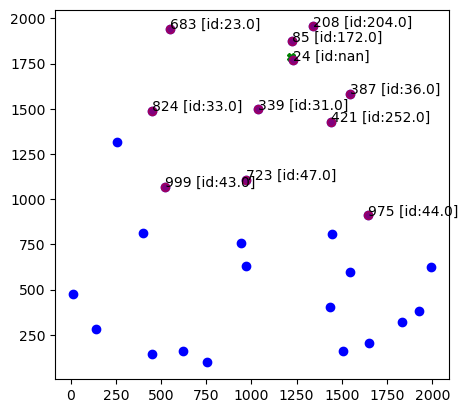

In [439]:
%matplotlib inline
plt.plot(row['x_img1'], row['y_img1'], "Xg")
plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], "ob")
plt.plot(plus_xy["x_img1"].iloc[ind[0]], plus_xy["y_img1"].iloc[ind[0]], "or", alpha=.5)
for ii,dd in zip(ind[0],dist[0]):
    plt.text(plus_xy["x_img1"].iloc[ii], plus_xy["y_img1"].iloc[ii],
        "%2d [id:%s]" % (dd, plus_xy["TRACK_ID"].iloc[ii])
        )

plt.gca().set_aspect(1)


### for each -1/2 defect find the closest +1/2 neighbour, which is not his pair

%matplotlib qt


def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

def pair_trajectories(mlabel, plabel, minimal_track=15):
    m_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==mlabel, 
        plus_minus_df["charge"]==-.5,
        )
    p_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==plabel, 
        plus_minus_df["charge"]==.5
        )
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:
        return equlalize_trajectories(plus_minus_df, p_idx, m_idx)
    
def get_non_pair_pdef():
    df = pd.DataFrame(columns=["FRAME","TRACK_ID","x_img1","y_img1","ang1"])
    maximal_pair_distance = 1.5*center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
    for num,frame in enumerate(dff_.index):
        p_idx = np.logical_and.reduce((
            plus_minus_df["FRAME"]==frame, 
            plus_minus_df["charge"]==.5,
            plus_minus_df["TRACK_ID"] != n,
        ))
        plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

        tree = KDTree(plus_xy[["x_img1","y_img1"]])
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]
        
        if len(ind):
            df = pd.concat([df, plus_xy[["FRAME","TRACK_ID","x_img1","y_img1","ang1"]].iloc[ind]])

    df.set_index('FRAME', inplace=True)
    return df

non_pair_rel_angle = []
fig, ax = plt.subplots(1,1, figsize=(10,10))  
count = 0
for m, n in zip(pairs_df["minus"][:], pairs_df["plus"][:40]):
    dff_ = pair_trajectories(m,n)    
    
    if dff_ is not None:
        maximal_pair_distance = center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
        # plt.figure()        
        # count +=1
        # print(count)
        # if count>20:
        #     break
        
        # find next nearest neighbour, which is not a pair
        colors = plt.cm.jet(np.linspace(0, 1, num=len(dff_)))
        non_pair_df = get_non_pair_pdef()
        mp_angle = np.arctan2(np.median(dff_["ym"]) - np.median(non_pair_df["y_img1"]), 
                            np.median(dff_["xm"]) - np.median(non_pair_df["x_img1"])) 
        if mp_angle<0:
            mp_angle = mp_angle + 2*np.pi

        non_pair_df["rel_ang"] = non_pair_df["ang1"] - mp_angle
        non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] = non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] + 2*np.pi

        if len(non_pair_df):
            non_pair_rel_angle.append(
                circmean(non_pair_df["rel_ang"])
                )
            # print(non_pair_df.head())
            # break        

        for num,frame in enumerate(dff_.index):
            p_idx = np.logical_and.reduce((
                plus_minus_df["FRAME"]==frame, 
                plus_minus_df["charge"]==.5,
                # plus_minus_df["TRACK_ID"] != n,
            ))
            plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

            tree = KDTree(plus_xy[["x_img1","y_img1"]])
            # find +1/2 defects within radius (r=maximal_pair_distance)
            ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]

            # plt.figure()
            # non-pair neighbour
            plt.plot(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind], "or", alpha=.6)
            plt.quiver(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind],
                np.cos(plus_xy["ang1"].iloc[ind]), -np.sin(plus_xy["ang1"].iloc[ind]), 
                headaxislength=0, headwidth=0, headlength=0, color='r', scale=25, alpha=.6)

            # plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], ".b", alpha=.05)
            # plt.quiver(plus_xy["x_img1"], plus_xy["y_img1"],
            #     np.cos(plus_xy["ang1"]), -np.sin(plus_xy["ang1"]), 
            #     headaxislength=0, headwidth=0, headlength=0, color='b', scale=30, alpha=.05)

            circle1 = plt.Circle((dff_["xm"].loc[frame], dff_["ym"].loc[frame]), maximal_pair_distance, color='r', alpha=.05, fill=False)
            plt.gca().add_patch(circle1)
            # # plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], marker="$M$", color=colors[num])
            # # plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], marker="$P$", color=colors[num])

            # pair neighbours
            plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            for i in range(3):
                plt.quiver(dff_["xm"].loc[frame], dff_["ym"].loc[frame],
                    np.cos(dff_['angm'+str(i+1)].loc[frame]), -np.sin(dff_['angm'+str(i+1)].loc[frame]), 
                    headaxislength=0, headwidth=0, headlength=0, color='m', scale=35, alpha=.2) 

            plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            plt.quiver(dff_["xp"].loc[frame], dff_["yp"].loc[frame],
            np.cos(dff_["angp1"].loc[frame]), -np.sin(dff_["angp1"].loc[frame]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=45, alpha=.2)

plt.gca().set_box_aspect(1)

plt.figure()
plt.hist(np.array(non_pair_rel_angle)*180/np.pi,10, density=False, rwidth=.9, alpha=.5, color="red")

## Pair Trajectories

In [440]:
%matplotlib qt

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

minimal_track = 5

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
pair_stat = []
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (5 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        mp_distance.append(((xm-xp)**2 + (ym-yp)**2)**.5)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi)]
                          )

        for i in range(3):
            ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

        ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
        ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

        ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
        ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

        ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
        ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
        # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
        ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
        ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)

In [441]:
len(pair_stat)

91

Text(0.5, 1.0, '$Angle ~variation ~of ~+1/2 ~Defects$')

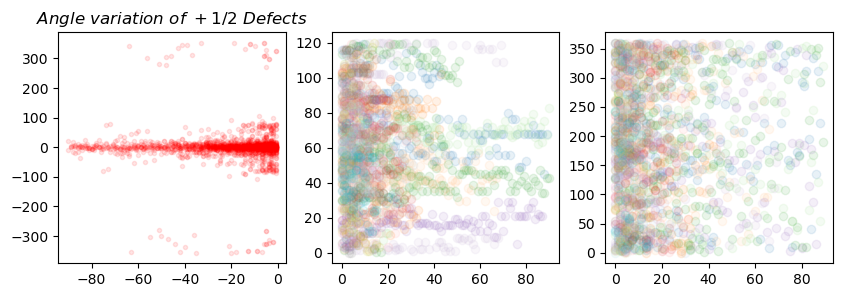

In [442]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
pangles_early = []
pangles_late = []
mangles = []
mpangles = []
p_vel_angles = []
p_vel_angles_rel = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    pang = np.diff(angs[0])
    # pang[pang<0] = pang[pang<0] + 2*np.pi
    ax[0].plot(-len(pang)+np.arange(len(pang)), (pang+np.pi % (2*np.pi))  * 180/np.pi-180, ".", color="red", alpha=.1)
    ax[1].plot(np.arange(len(angs[1][0])), angs[1][0] % (2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)

    pangles.append(angs[0][:-1])
    pangles_early.append(angs[0][:-10])
    pangles_late.append(angs[0][-10:])
    mangles.append(np.concatenate(angs[1]))
    p_vel_angles.append(angs[2])
    p_vel_angles_rel.append(angs[3])

    # mpangle = np.min((angs[1] - angs[0]) %(2*np.pi), axis=0)#[-3:]
    mpangles.append(np.concatenate(angs[1] - angs[0]))

    ax[2].plot(np.arange(len(angs[2])), np.array(angs[2]) %(2*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    
    # if num>25:
    #     break

# plt.figure(figsize=(3,3))
# plt.hist(np.concatenate(mpangles) % (2/3*np.pi) *180/np.pi , alpha=.2, rwidth=.9)
# ax[0].set_ylim([-10,370])
# ax[1].set_ylim([-10,130])
# ax[1].set_ylim([0,120])
# ax[0].set_xlim([-1,0])
ax[0].set_title("$Angle ~variation ~of ~+1/2 ~Defects$")

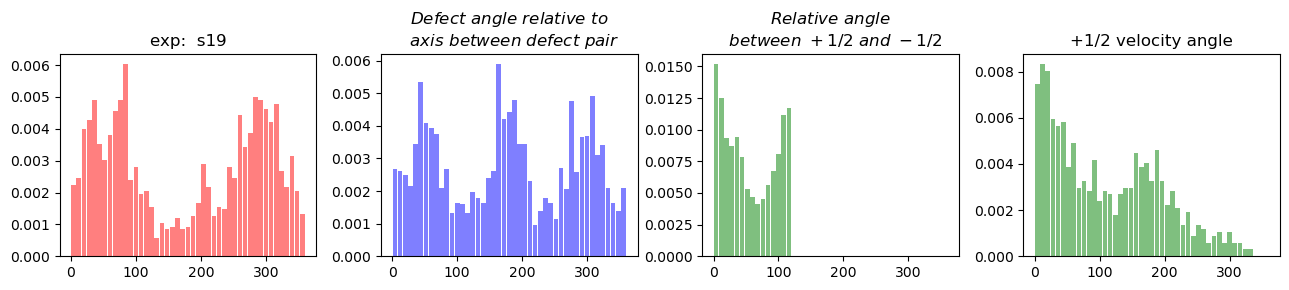

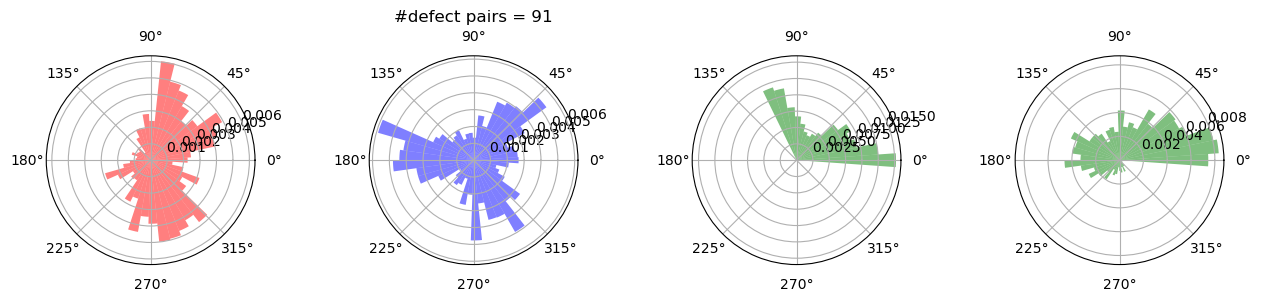

In [443]:
%matplotlib inline
SAVE = True
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
pangle = np.concatenate(pangles) + 0 * 2*np.pi
mangle = np.concatenate(mangles) + 0 * 2/3*np.pi #2*np.pi * np.ones((1,100)).ravel() #
mpangle = np.concatenate(mpangles) + 0 * 2/3*np.pi
p_vel_angle = np.concatenate(p_vel_angles) + 0 * 2*np.pi

pangle = pangle % (2*np.pi)
mangle = mangle % (2*np.pi)
mpangle = mpangle % (2/3*np.pi)

fig1, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(13,3))
ax1.set_title(r"exp:  " + experiment)
ax2.set_title("$Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair $")
ax3.set_title("$Relative ~angle$ \n $~between ~+1/2 ~and ~-1/2$")
ax4.set_title(r"+1/2 velocity angle")
pn, _, _ =  ax1.hist(pangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="red")
mn, _, _ = ax2.hist(mangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="blue")
mpn, _, _ =  ax3.hist(mpangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
p_vel, _, _ =  ax4.hist(p_vel_angle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
plt.tight_layout()
if SAVE:
    fig1.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_hist_" + experiment +".png")


# plt.clf()
width = 2 * np.pi / bins_number
fig2, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(13,3))
ax1.bar(bins[:bins_number], pn, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], mn, color="blue",width=width, bottom=0.0, alpha=.5)
ax3.bar(bins[:bins_number], mpn, color="green",width=width, bottom=0.0, alpha=.5)
ax4.bar(bins[:bins_number], p_vel, color="green",width=width, bottom=0.0, alpha=.5)
ax2.set_title(r"#defect pairs = " + str(len(pair_stat)))
plt.tight_layout()
if SAVE:
    fig2.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_polhist_" + experiment +".png")


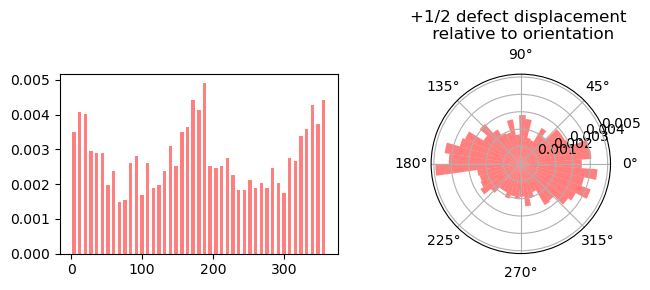

In [444]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p_vel_angle_rel =  np.concatenate(p_vel_angles) % (2*np.pi)

n, _, _ =  ax1.hist(p_vel_angle_rel*180/np.pi, bins*180/np.pi, density=True, rwidth=.6, alpha=.5, color="red")
ax2.bar(bins[:bins_number], n, color="red",width=width, bottom=0.0, alpha=.5)
plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
if SAVE:
    fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/p_direction_vs_displacement_" + experiment +".png")

Text(0.5, 1.0, 'Eary vs. Late +1/2 Defect Orienatation')

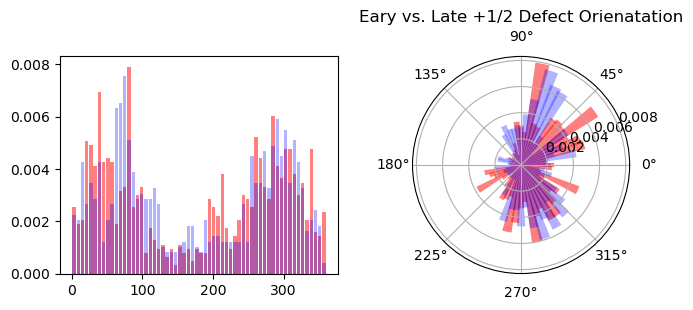

In [445]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 60
bins = np.linspace(0, 2*np.pi, bins_number+1)

pangle_early =  np.concatenate(pangles_early) % (2*np.pi)
pangle_late =  np.concatenate(pangles_late) % (2*np.pi)

n1, _, _ =  ax1.hist(pangle_early*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.5, color="red")
n2, _, _ =  ax1.hist(pangle_late*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.3, color="blue")
ax2.bar(bins[:bins_number], n1, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], n2, color="blue",width=width, bottom=0.0, alpha=.3)
# plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
plt.title("Eary vs. Late +1/2 Defect Orienatation")

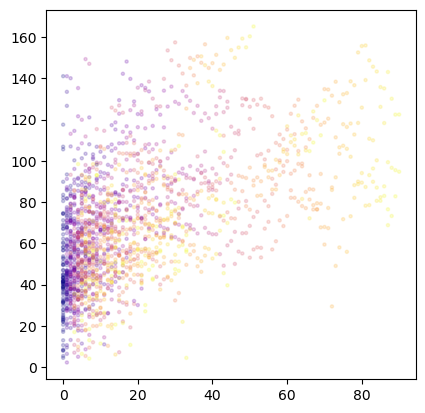

In [446]:
mp_distance_mat = np.zeros([len(mp_distance), len(max(mp_distance, key = lambda x: len(x)))])
mp_distance_mat[:] = np.nan
for i, dist in enumerate(mp_distance):
    # print(i, j)
    plt.scatter(np.arange(len(dist)), np.flip(dist), c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)    
    mp_distance_mat[i,0:len(dist)] = np.flip(dist)
    
plt.gca().set_box_aspect(1)  

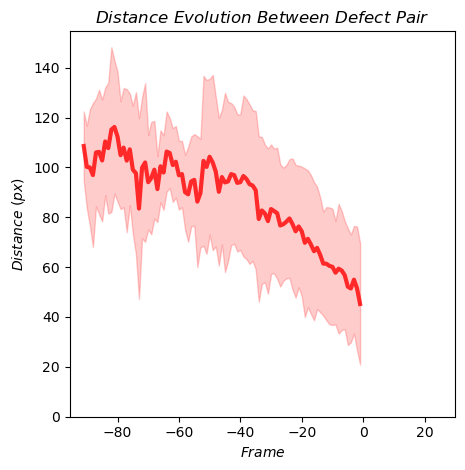

In [447]:
%matplotlib inline
for i in range(mp_distance_mat.shape[0]):
    y = mp_distance_mat[i,:][~np.isnan(mp_distance_mat[i,:])]
    # plt.scatter(np.arange(len(y)), y, c=np.arange(len(y)), s=3, alpha=.2, cmap="plasma")


mean, stdiv = np.flip(np.nanmean(mp_distance_mat, axis=0)), np.flip(np.nanstd(mp_distance_mat, axis=0))
max_frame = mp_distance_mat.shape[1]

plt.plot(np.arange(len(mean))-max_frame, mean, "r-", alpha=.8, linewidth=3)
plt.fill_between(np.arange(len(mean))-max_frame, mean-stdiv, mean+stdiv, color="red", alpha=.2)
plt.ylim([0,None])
plt.xlim([None,30])
plt.gca().set_box_aspect(1)  
plt.xlabel('$Frame$')
plt.ylabel(r'$Distance ~(px)$') #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pair$')
plt.tight_layout()
if SAVE:
    plt.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/defect_pair_distance_" + experiment +".png")

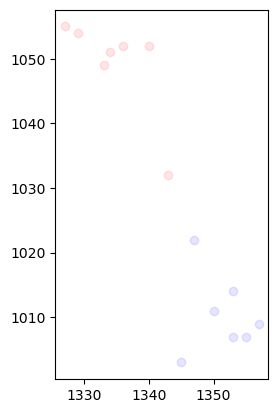

In [448]:
plt.plot(xp, yp,"ro", alpha=.1)
plt.plot(xm, ym,"bo", alpha=.1)
plt.gca().set_aspect(1)